# CROSS SECTINONAL DATA ANALYSIS

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

# Ignore harmless warnings:
warnings.filterwarnings("ignore")

# Set figure size and dpi. Note that high values might cause lag |in slow machines.
plt.rcParams['figure.figsize'] = (15,7)
plt.rcParams['figure.dpi'] = 150

# Set pandas column display format:
pd.options.display.float_format = '{:.4f}'.format

## DATA READ

In [88]:
# Set data directory (adjust this variable as needed.)
data_dir = '../data/'

# Read data into memory:
df = pd.read_csv(data_dir + 'data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2646 entries, 0 to 2645
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    2646 non-null   object 
 1   code       2646 non-null   object 
 2   year       2646 non-null   int64  
 3   n          2646 non-null   float64
 4   pop        2646 non-null   float64
 5   I          2646 non-null   float64
 6   y          2646 non-null   float64
 7   TRADE      2646 non-null   float64
 8   INST       2646 non-null   float64
 9   HC         2646 non-null   float64
 10  FINANCIAL  2646 non-null   float64
 11  OECD       2646 non-null   int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 248.2+ KB


## DATA FIXES

In [89]:
# Ignore countries with extereme values:
to_ignore = ['SGP', 'MUS']

# Filter out such countries:
df = df.query("code not in @to_ignore")

# Take natural logarithms:
df['ln_y'] = np.log(df['y'])
df['ln_FINANCIAL'] = np.log(df['FINANCIAL'])
df['ln_TRADE'] = np.log(df['TRADE'])
df['ln_I'] = np.log(df['I'])

# Define squared variables
df['ln_FINANCIAL_sq'] = np.square(df['ln_FINANCIAL'])
df['ln_TRADE_sq'] = np.square(df['ln_TRADE'])
df['ln_I_sq'] = np.square(df['ln_I'])


In [90]:
# Define intervals:
intervals = [(1996, 2008),
             (2009, 2022)]

df['interval'] = np.nan

# Assign intervals to the 'interval' column
for interval in intervals:
    start, end = interval
    mask = (df['year'] >= start) & (df['year'] <= end)
    df.loc[mask, 'interval'] = f'{start}-{end}'

In [91]:
split_data = df.groupby(by=['country', 'code', 'interval'],
                        as_index=False).mean()

## MODEL
#### $\ln(y_{it}) = \beta_0 + \beta_1 I_{it} + \beta_2 n_{it} + \beta_3 HC_{it} + \beta_4 INST_{it} + \beta_5 TRADE_{it} + \beta_6 FINANCIAL_{it} + \beta_7 OECD + \epsilon_{it}$
#### for   $t=T$, and $i ∈ C$  

Where:  
      
$I =$ Investment rate (as percentage of GDP).  
$n =$ Population growth rate (%).  
$HC =$ Human Capital Index.  
$INST =$ Rule of law index.  
$TRADE =$ Trade openness index.  
$FINANCIAL =$ Financial openness index.  
$OECD =$ Dummy variable. 1 indicates OECD countries, 0 indicates non-OECD countries.   
$T =$ Target year for cross-sectional data.  
$C =$ Set of ountries.  
$\epsilon =$ Error.

## MODEL ESTIMATION FOR 1996 - 2008 and 2009-2022 AVERAGE CROSS-SECTIONAL DATA

In [114]:
def plot_diagnostics(model, endog) -> None:
    """OLS Diagnostics plot utility"""

    # Create the figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Residual Normality Q-Q Plot
    plot_acf(model.resid, lags=10, ax=axes[0, 0])
    axes[0, 0].set_title('Residual Autocorrelation Plot', fontdict={'weight': 'bold'})

    # Predicted vs. Actual Value Plot
    axes[0, 1].scatter(model.fittedvalues, endog, color='C0', alpha=0.6)
    axes[0, 1].plot(endog, endog, color='red', linestyle='--')
    axes[0, 1].set_title('Predicted vs. Actual Value Plot', fontdict={'weight': 'bold'})
    axes[0, 1].set_xlabel('PREDICTED VALUES')
    axes[0, 1].set_ylabel('ACTUAL VALUES')

    # Residual Scatter Plot
    axes[1, 0].scatter(model.fittedvalues, model.resid, color='C0', alpha=0.6)
    axes[1, 0].axhline(y=0, color='black', linestyle='--')
    axes[1, 0].set_title('Residual Scatter Plot', fontdict={'weight': 'bold'})
    axes[1, 0].set_xlabel('')
    axes[1, 0].set_xticks([])
    axes[1, 0].set_ylabel('RESIDUAL VALUES')

    # Residuals KDE Plot
    sns.kdeplot(model.resid, ax=axes[1, 1], color='C0', shade=True)
    axes[1, 1].set_title('Residuals KDE Plot', fontdict={'weight': 'bold'})
    axes[1, 1].set_xlabel('RESIDUAL VALUES')
    axes[1, 1].set_ylabel('DENSITY')

    plt.tight_layout()
    plt.show()

In [115]:
split_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          192 non-null    object 
 1   code             192 non-null    object 
 2   interval         192 non-null    object 
 3   year             192 non-null    float64
 4   n                192 non-null    float64
 5   pop              192 non-null    float64
 6   I                192 non-null    float64
 7   y                192 non-null    float64
 8   TRADE            192 non-null    float64
 9   INST             192 non-null    float64
 10  HC               192 non-null    float64
 11  FINANCIAL        192 non-null    float64
 12  OECD             192 non-null    float64
 13  ln_y             192 non-null    float64
 14  ln_FINANCIAL     192 non-null    float64
 15  ln_TRADE         192 non-null    float64
 16  ln_I             192 non-null    float64
 17  n_sq            

In [121]:
# Estimate 1996-2008 cross-section data:

# Define pre-crisis data:
pre_crisis = split_data.query('interval == "1996-2008"')

# create and fit model with the assumption that error ~ N(0, sigma), so we use nonrobust covariance matrix: 
pre_crisis_model = smf.ols(formula='ln_y ~ 1 + ln_I + n + HC + INST + ln_TRADE + ln_FINANCIAL + OECD',
                           data=pre_crisis)\
                               .fit(cov_type='nonrobust')

print(pre_crisis_model.summary(title=f'1996-2008 YEAR AVERAGE CROSS-SECTIONAL OLS'))

# White's Test:
name = ['Lagrange Multiplier statistic', 'p-value', 'f-value', 'f p-value']
white_test = sms.het_white(pre_crisis_model.resid,
                           pre_crisis_model.model.exog)

result = lzip(name, white_test)
print(f"\n\nWhite's Test for Heteroskedasticity (1996-2009)):\n\n")

# Print white's test results:
for stat, value in result:
    print(f"{stat}: {value:.4f}")

# Durbin-Watson test:
print(f'\n\nDurbin-Watson Test statistic: {np.round(sms.durbin_watson(resids=pre_crisis_model.resid), 4)}')

                  1996-2008 YEAR AVERAGE CROSS-SECTIONAL OLS                  
Dep. Variable:                   ln_y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     79.19
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           3.09e-35
Time:                        16:14:21   Log-Likelihood:                -78.345
No. Observations:                  96   AIC:                             172.7
Df Residuals:                      88   BIC:                             193.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.0405      1.102      3.666   

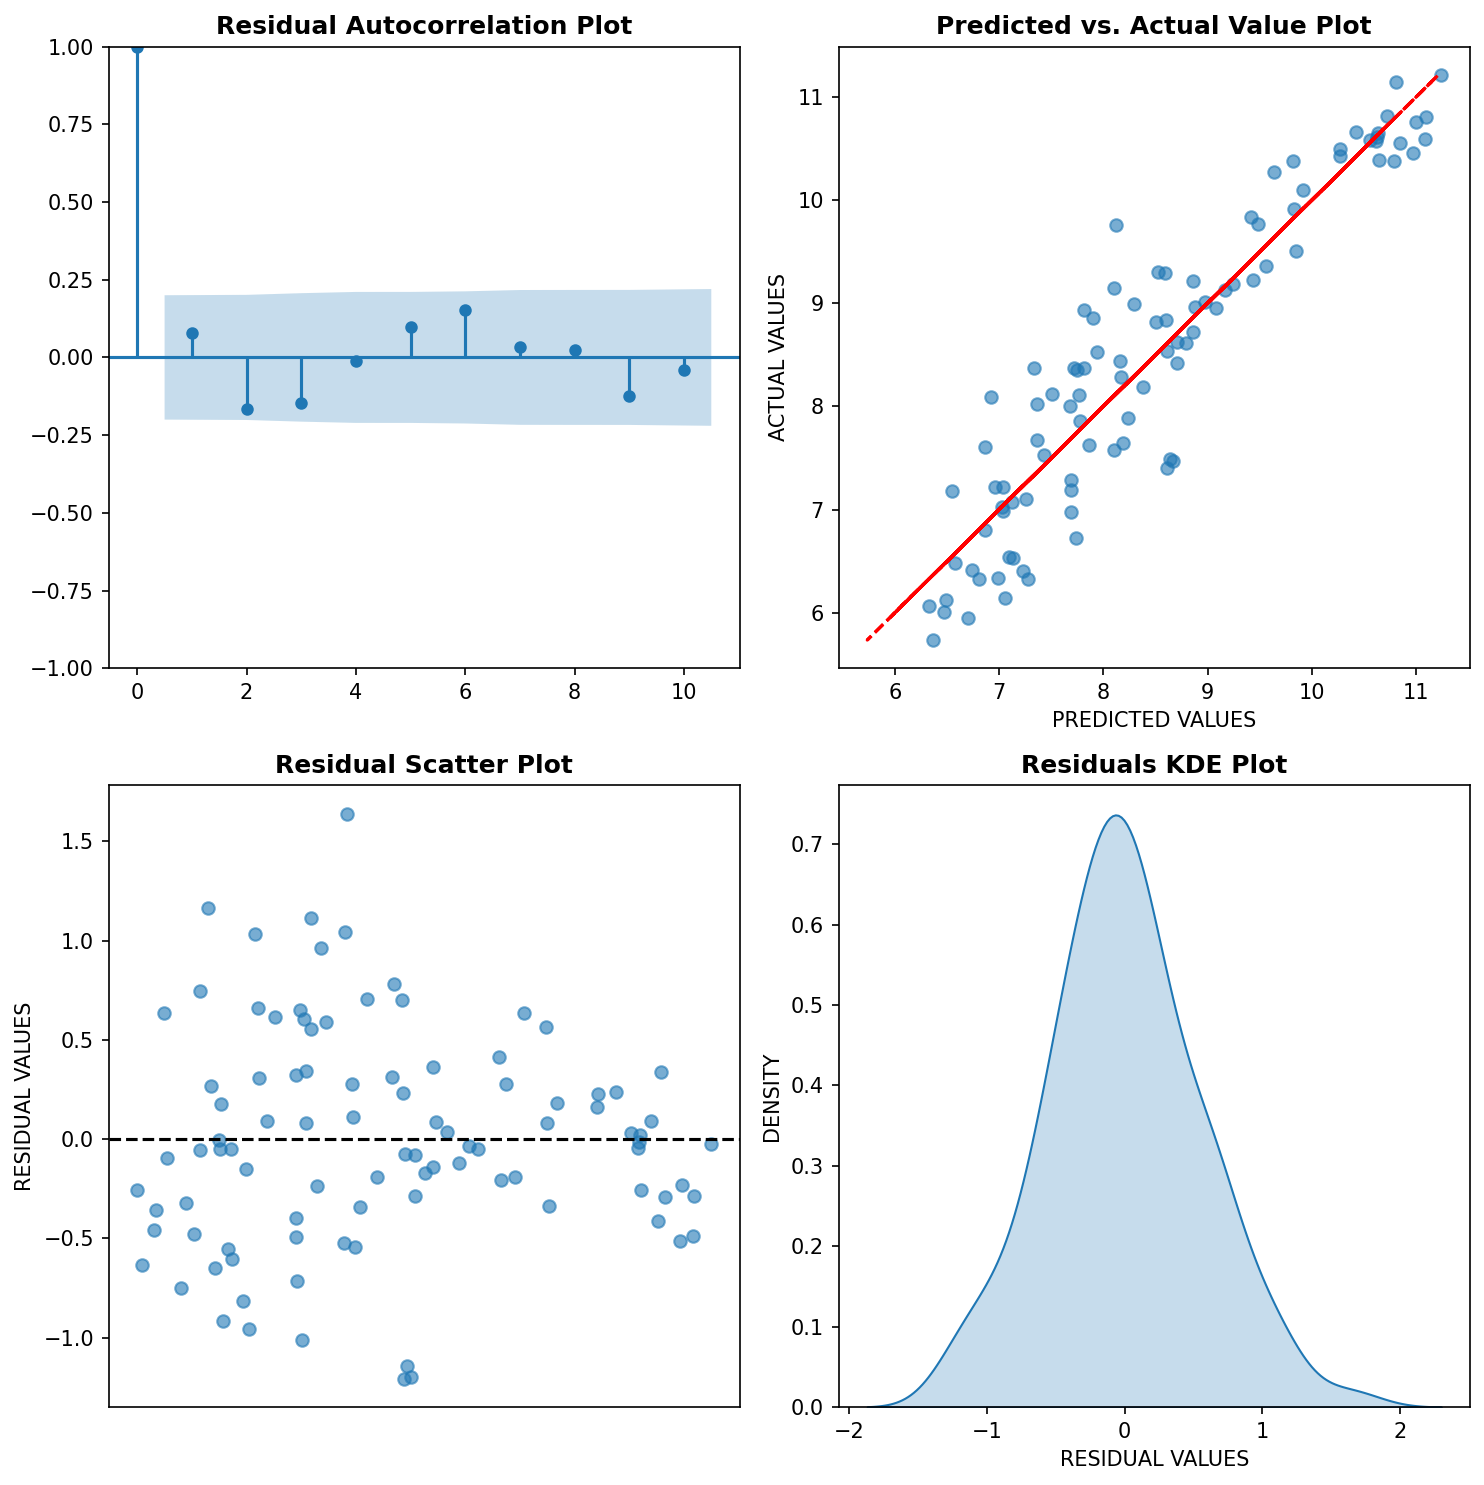

In [117]:
# Plot the OLS diagnostics for 1996- 2008:
plot_diagnostics(model=pre_crisis_model, endog=pre_crisis['ln_y'])

In [120]:
# Define post-crisis data:
post_crisis = split_data.query('interval == "2009-2022"')

# create and fit model with the assumption that error ~ N(0, sigma), so we use nonrobust covariance matrix: 
post_crisis_model = smf.ols(formula='ln_y ~ 1 + ln_I + n + HC + INST + ln_TRADE + ln_FINANCIAL + OECD',
                            data=post_crisis)\
                                .fit(cov_type='nonrobust')

print(post_crisis_model.summary(title=f'2009-2022 YEAR AVERAGE CROSS-SECTIONAL OLS'))

# White's Test:
name = ['Lagrange Multiplier statistic', 'p-value', 'f-value', 'f p-value']
white_test = sms.het_white(post_crisis_model.resid,
                           post_crisis_model.model.exog)

result = lzip(name, white_test)
print(f"\n\nWhite's Test for Heteroskedasticity (2009-2022)):\n\n")

# Print white's test results:
for stat, value in result:
    print(f"{stat}: {value:.4f}")


print(f'\n\nDurbin-Watson Test statistic: {np.round(sms.durbin_watson(resids=post_crisis_model.resid), 4)}')

                  2009-2022 YEAR AVERAGE CROSS-SECTIONAL OLS                  
Dep. Variable:                   ln_y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     104.2
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           8.24e-40
Time:                        16:13:58   Log-Likelihood:                -63.748
No. Observations:                  96   AIC:                             143.5
Df Residuals:                      88   BIC:                             164.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.7213      0.966      4.886   

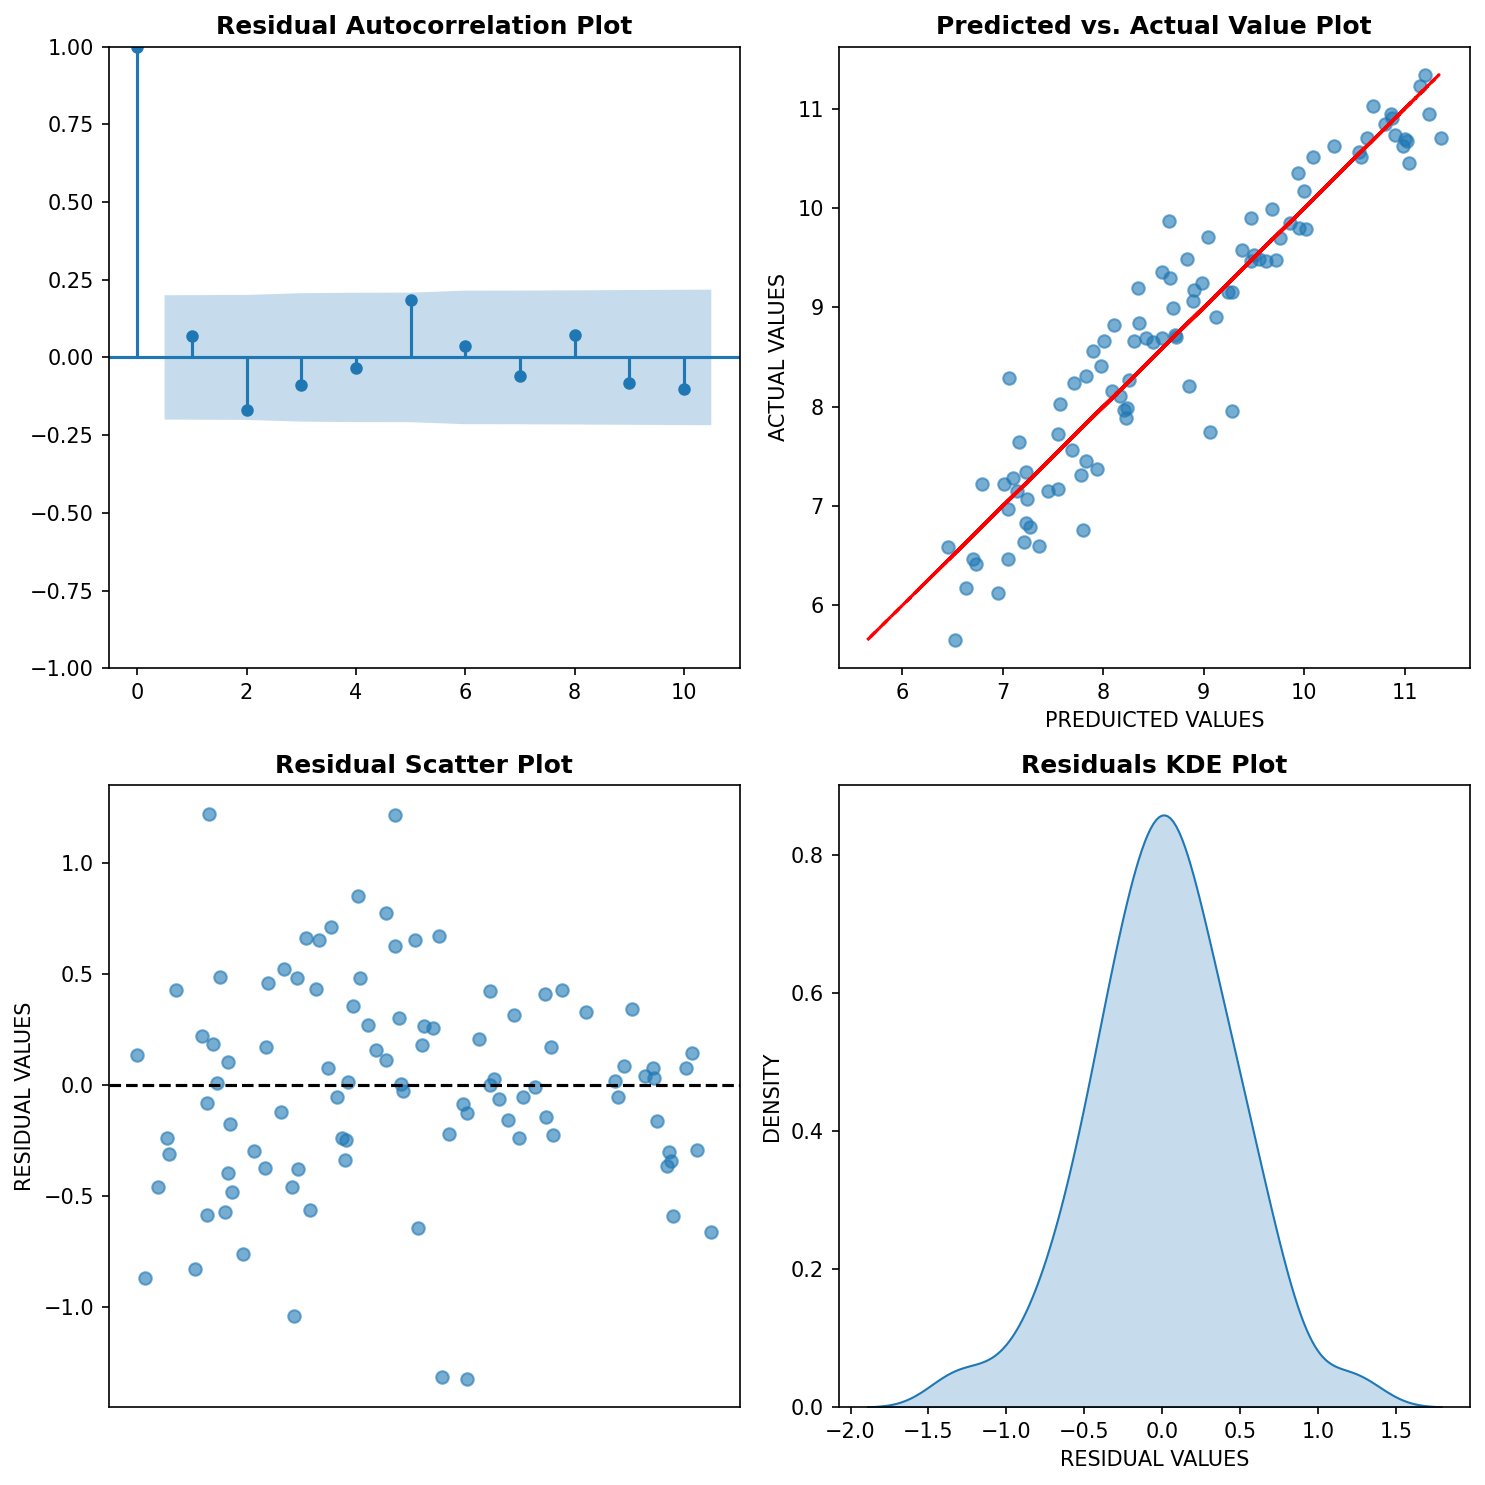

In [97]:
# Plot diagnostics data:
plot_diagnostics(model=post_crisis_model, endog=post_crisis['ln_y'])

## QUADRATIC MODELS 
#### We did not include this part in research

In [98]:
investment_effects  = smf.ols(formula='ln_y ~ 1 + ln_I + ln_I_sq',
                              data=split_data.drop(columns='interval').\
                                  groupby(by=['country', 'code'])\
                                      .mean()).fit(cov_type='nonrobust')

print(investment_effects.summary(title='INVESTMENT EFFECTS'))

                              INVESTMENT EFFECTS                              
Dep. Variable:                   ln_y   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     9.377
Date:                Wed, 05 Jun 2024   Prob (F-statistic):           0.000195
Time:                        23:35:38   Log-Likelihood:                -163.20
No. Observations:                  96   AIC:                             332.4
Df Residuals:                      93   BIC:                             340.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.5659      5.950     -2.448      0.0

In [99]:
population_growth_effects = smf.ols(formula='ln_y ~ 1 + n + n_sq',
                                    data=split_data.drop(columns='interval').\
                                        groupby(by=['country', 'code'])\
                                            .mean()).fit(cov_type='nonrobust')

print(population_growth_effects.summary(title='POPULATION GROWTH EFFECTS'))

                          POPULATION GROWTH EFFECTS                           
Dep. Variable:                   ln_y   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     42.04
Date:                Wed, 05 Jun 2024   Prob (F-statistic):           9.89e-14
Time:                        23:35:38   Log-Likelihood:                -141.11
No. Observations:                  96   AIC:                             288.2
Df Residuals:                      93   BIC:                             295.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.6200      0.165     58.379      0.0

In [100]:
trade_effects = smf.ols(formula='ln_y ~ 1 + ln_TRADE + ln_TRADE_sq',
                        data=split_data.drop(columns='interval').\
                            groupby(by=['country', 'code'])\
                                .mean()).fit(cov_type='nonrobust')

print(trade_effects.summary(title='TRADE EFFECTS'))

                                TRADE EFFECTS                                 
Dep. Variable:                   ln_y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     5.134
Date:                Wed, 05 Jun 2024   Prob (F-statistic):            0.00767
Time:                        23:35:38   Log-Likelihood:                -166.99
No. Observations:                  96   AIC:                             340.0
Df Residuals:                      93   BIC:                             347.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       8.1825      8.681      0.943      

In [101]:
financial_effects = smf.ols(formula='ln_y ~ 1 + ln_FINANCIAL + ln_FINANCIAL_sq',
                            data=split_data.drop(columns='interval').\
                                groupby(by=['country', 'code'])\
                                    .mean()).fit(cov_type='nonrobust')

print(financial_effects.summary(title='FINANCIAL EFFECTS'))

                              FINANCIAL EFFECTS                               
Dep. Variable:                   ln_y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     59.27
Date:                Wed, 05 Jun 2024   Prob (F-statistic):           2.54e-17
Time:                        23:35:38   Log-Likelihood:                -132.57
No. Observations:                  96   AIC:                             271.1
Df Residuals:                      93   BIC:                             278.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.2511      3.239     

In [102]:
human_capital_effects = smf.ols(formula='ln_y ~ 1 + HC + HC_sq',
                            data=split_data.drop(columns='interval').\
                                groupby(by=['country', 'code'])\
                                    .mean()).fit(cov_type='nonrobust')

print(human_capital_effects.summary(title='HUMAN CAPITAL EFFECTS'))

                            HUMAN CAPITAL EFFECTS                             
Dep. Variable:                   ln_y   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     152.0
Date:                Wed, 05 Jun 2024   Prob (F-statistic):           4.89e-30
Time:                        23:35:38   Log-Likelihood:                -102.35
No. Observations:                  96   AIC:                             210.7
Df Residuals:                      93   BIC:                             218.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7170      0.955      3.892      0.0